In [13]:
pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   - -------------------------------------- 30.7/625.1 kB 1.4 MB/s eta 0:00:01
   -------------------- ------------------- 317.4/625.1 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------ --------------------------------- 0.5/2.8 MB 15.2 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 12.9 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 12.4 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 12.0 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


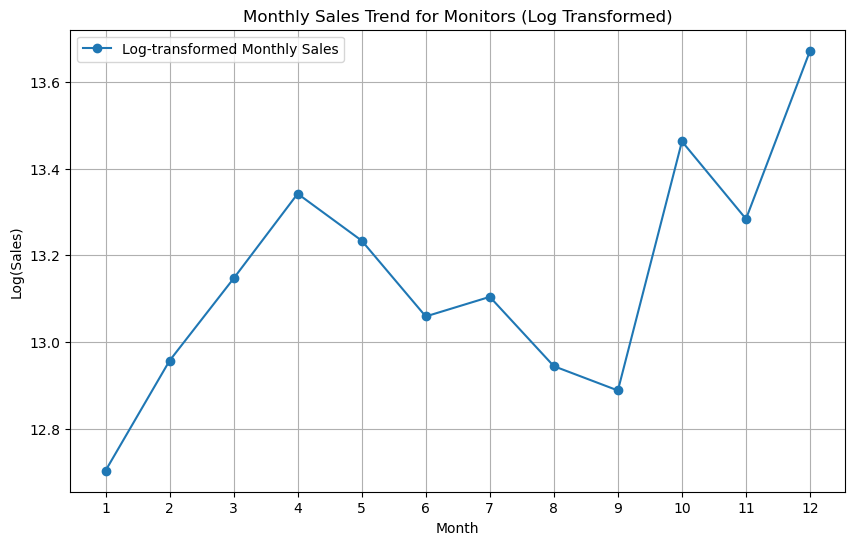

Best Polynomial Degree: 1
Mean Squared Error: 0.04944671681521412
Root Mean Squared Error: 0.222366177318436
R^2 Score: 0.5302277345390956


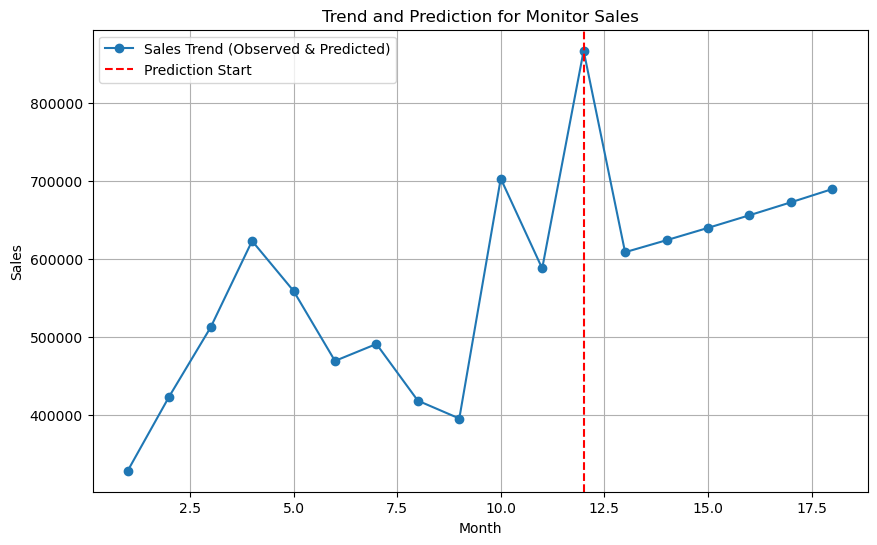

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the dataset
# Replace 'data/SalesData.csv' with the actual file path
data = pd.read_csv('data/SalesData.csv')

# Step 2: Parse dates correctly
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y %H:%M')

# Step 3: Filter data for 'Monitors' in Product Category safely
monitor_data = data[data['Product Category'] == 'Monitors'].copy()

# Add a new column for Month safely
monitor_data['Month'] = monitor_data['Order Date'].dt.month

# Step 4: Calculate total monthly sales
monthly_sales = monitor_data.groupby('Month').agg({'Sales': 'sum'}).reset_index()

# Step 5: Handle outliers using log transformation
# Log transformation to reduce skewness and minimize the impact of outliers
monthly_sales['Sales'] = np.log1p(monthly_sales['Sales'])

# Step 6: Visualize trends in sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['Month'], monthly_sales['Sales'], marker='o', label='Log-transformed Monthly Sales')
plt.title('Monthly Sales Trend for Monitors (Log Transformed)')
plt.xlabel('Month')
plt.ylabel('Log(Sales)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.show()

# Step 7: Prepare data for predictive analysis
X = monthly_sales[['Month']]  # Feature (Months)
y = monthly_sales['Sales']    # Target (Log-transformed Sales)

# Evaluate polynomial degrees
best_degree = 0
best_rmse = float('inf')
for degree in range(1, 5):  # Test polynomial degrees 1 to 4
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = Ridge(alpha=1.0)  # Regularized model to prevent overfitting
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_degree = degree

# Use the best polynomial degree for final model
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Best Polynomial Degree: {best_degree}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Step 8: Forecast future sales for upcoming months
future_months = pd.DataFrame({'Month': range(13, 19)})  # Months 13 to 18 (6 future months)
future_months_poly = poly.transform(future_months)
future_months_scaled = scaler.transform(future_months_poly)
future_sales = model.predict(future_months_scaled)

# Reverse log transformation for predicted sales
future_sales = np.expm1(future_sales)

# Combine actual and predicted data for visualization
monthly_sales['Sales'] = np.expm1(monthly_sales['Sales'])  # Reverse log for original sales
future_df = pd.DataFrame({'Month': future_months['Month'], 'Sales': future_sales})
full_sales = pd.concat([monthly_sales, future_df])

# Step 9: Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(full_sales['Month'], full_sales['Sales'], marker='o', label='Sales Trend (Observed & Predicted)')
plt.axvline(x=12, color='red', linestyle='--', label='Prediction Start')
plt.title('Trend and Prediction for Monitor Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.show()
